In [1]:
import pandas as pd
import numpy as np 
from pathlib import Path
import json

import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler


from src.concrete.ml.sklearn import LinearRegression


/Users/marc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def format_large_numbers(x, pos):
    if np.abs(x) >= 1e9:
        return f'{x * 1e-9:.1f}B'  # Format as Billion
    elif np.abs(x) >= 1e6:
        return f'{x * 1e-6:.1f}M'  # Format as Million
    elif np.abs(x) >= 1e3:
        return f'{x * 1e-3:.1f}K'  # Format as Thousand
    else:
        return f'{x:.0f}'  # Less than 1,000

In [3]:
DATA_PATH = Path('demo-data/medicalpremium.csv')


In [4]:
df = pd.read_csv(DATA_PATH)
df['PremiumPrice'] = df['PremiumPrice']*0.011 # Convert price to EUR from INR
df = df.rename(columns={"BloodPressureProblems":"BPProblems", "AnyTransplants":"Transplants", "AnyChronicDiseases":"Diseases", 
                        "KnownAllergies":"Allergies", "HistoryOfCancerInFamily":"CancerFHx", "NumberOfMajorSurgeries":"Surgeries", 
                        "PremiumPrice":"Premium"})
df

,Age,Diabetes,BPProblems,Transplants,Diseases,Height,Weight,Allergies,CancerFHx,Surgeries,Premium
0,45,0,0,0,0,155,57,0,0,0,275.0
1,60,1,0,0,0,180,73,0,0,0,319.0
2,36,1,1,0,0,158,59,0,0,1,253.0
3,52,1,1,0,1,183,93,0,0,2,308.0
4,38,0,0,0,1,166,88,0,0,1,253.0
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,165.0
982,64,1,1,0,0,153,70,0,0,3,308.0
983,56,0,1,0,0,155,71,0,0,1,319.0
984,47,1,1,0,0,158,73,1,0,1,429.0


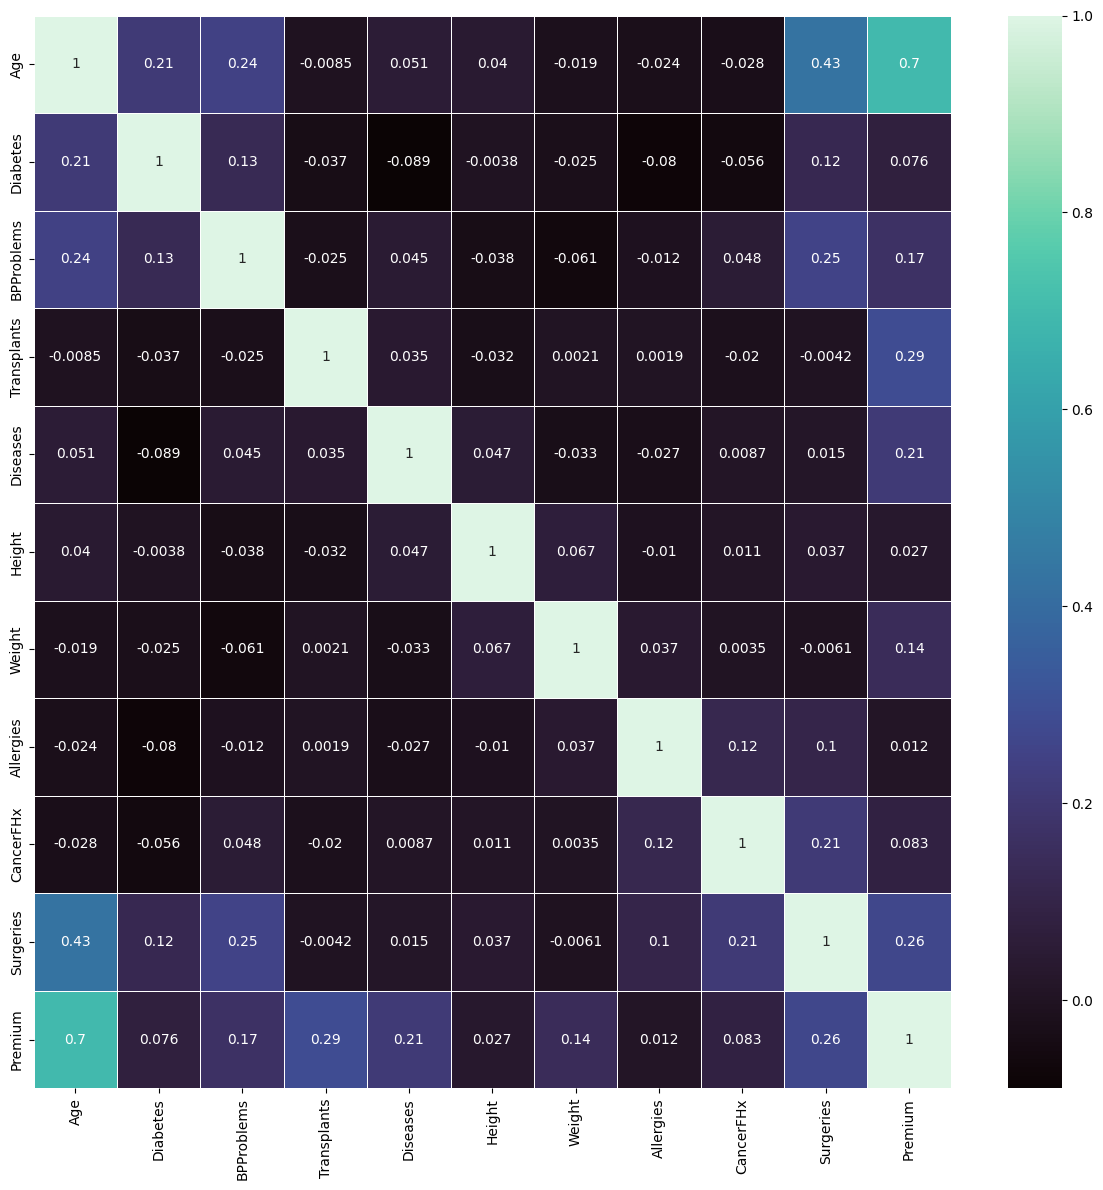

In [5]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax, cmap="mako")

fig.tight_layout()

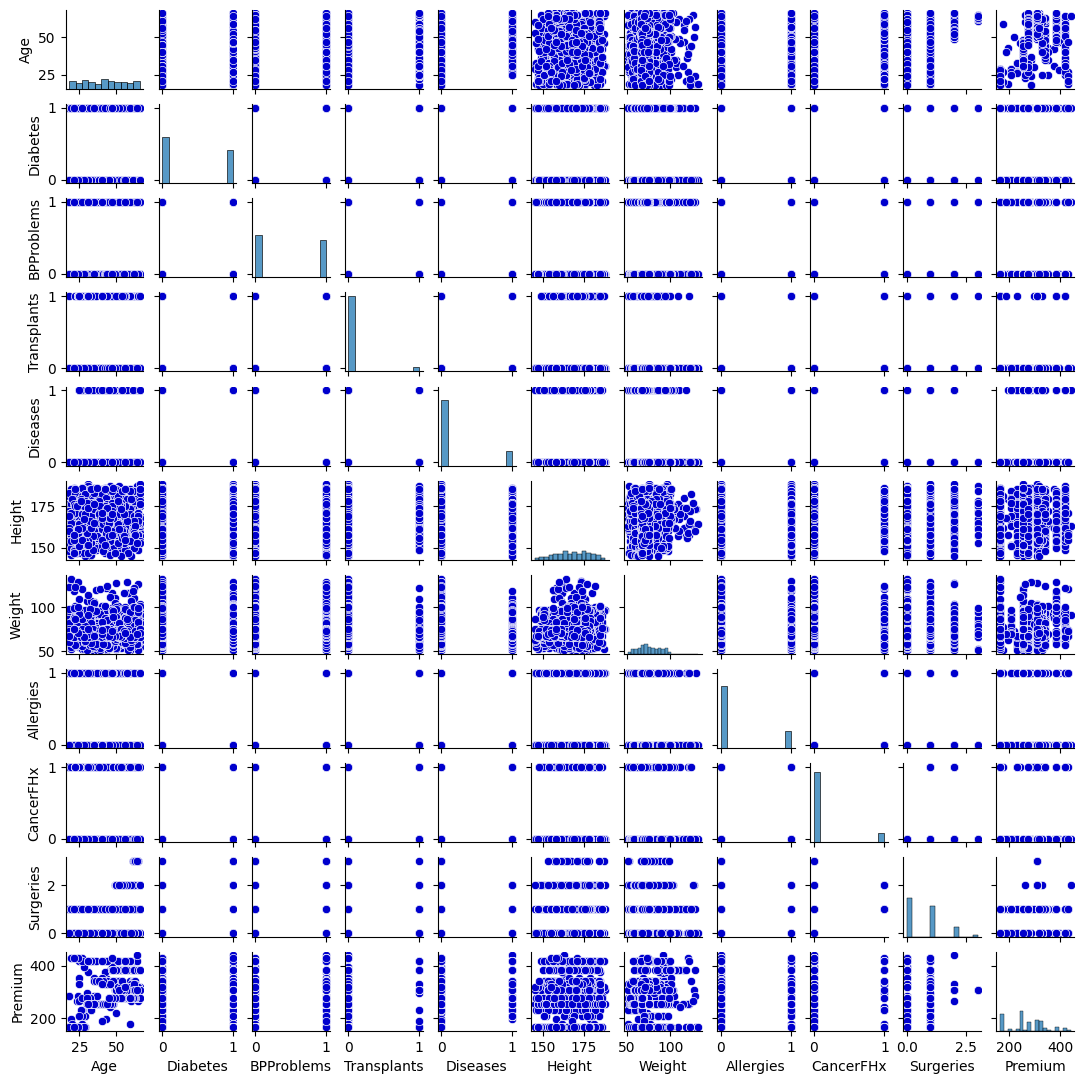

In [6]:
sns.pairplot(df, 
             height=1, aspect=1, 
             corner=False,
             plot_kws={'color': 'mediumblue'})
plt.show()

In [7]:
df['Age'] = df['Age'].astype(float)
df['Height'] = df['Height'].astype(float)
df['Weight'] = df['Weight'].astype(float)
df['Surgeries'] = df['Surgeries'].astype(float)
np.random.seed(0)

salaries = np.random.lognormal(mean=10, sigma=0.7, size=len(df))

salaries = np.clip(salaries, 20000, 90000)

# Add "Salary" column to DataFrame
df['Salary'] = salaries.astype(float)

df.describe()


,Age,Diabetes,BPProblems,Transplants,Diseases,Height,Weight,Allergies,CancerFHx,Surgeries,Premium,Salary
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,267.703854,30080.375630
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,68.730028,16550.685942
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,165.000000,20000.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,231.000000,20000.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,253.000000,21118.950247
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,308.000000,33758.818578
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,440.000000,90000.000000


In [8]:
X = df[['Age', 'Weight', 'Diseases', 'Salary']]
y = df['Premium']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = MinMaxScaler(feature_range=[-1, 1])
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rng = np.random.default_rng(123)
perm = rng.permutation(X_train.shape[0])

X_train = X_train[perm, ::]
y_train = y_train.values[perm]

In [10]:
linear_model = LinearRegression(n_bits=8)
linear_model.fit(X_train, y_train)

linear_model.compile(X_train)

dumped_model_path = Path("demo-data/linear_reg_multi_premium.json")

# Any kind of file-like object can be used 
with dumped_model_path.open("w") as f:
    # Dump the model in a file
    linear_model.dump(f)

with open("demo-data/linear_reg_multi_premium.json", 'r') as j:
     contents = json.loads(j.read())

model = contents['type_name']
serialized_value = np.array(contents['serialized_value']['_q_weights']['serialized_value'])

# Predict on the test set
y_pred_linear, proof = linear_model.predict(X_test, model, 
                                            serialized_value, fhe="execute")

# Calculate R^2 for the linear model
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Model R^2: {r2_linear:.2f}')


Linear Model R^2: 0.60


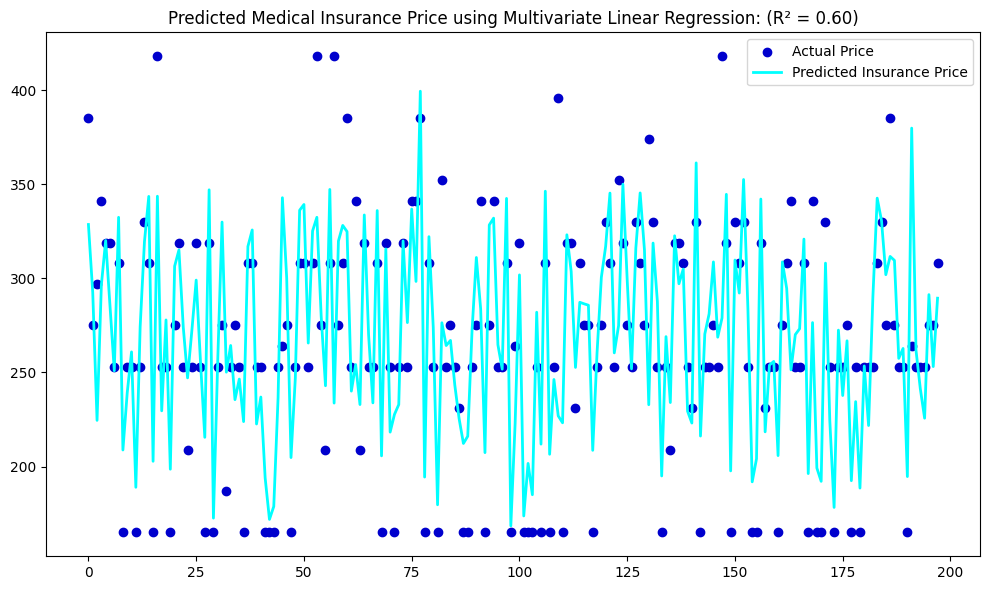

In [11]:
# Scatter plots and regression lines for the full set of variables
# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.scatter(range(len(y_test)), y_test, color='mediumblue', label='Actual Price')
ax1.plot(range(len(y_pred_linear)), y_pred_linear, color='cyan', label='Predicted Insurance Price', linewidth=2)
ax1.set_title(f'Predicted Medical Insurance Price using Multivariate Linear Regression: (R² = {r2_linear:.2f})')
ax1.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
ax1.legend()

fig.tight_layout()

plt.show()

In [12]:
linear_model = LinearRegression(n_bits=8)
scaler = MinMaxScaler(feature_range=[0,1])
X_scaled = scaler.fit_transform(X)


linear_model.fit(X_scaled, y)

linear_model.compile(X_scaled)

dumped_model_path = Path("demo-data/linear_reg_multi_premium.json")

# Any kind of file-like object can be used 
with dumped_model_path.open("w") as f:
    # Dump the model in a file
    linear_model.dump(f)

with open("demo-data/linear_reg_multi_premium.json", 'r') as j:
     contents = json.loads(j.read())

model = contents['type_name']
serialized_value = np.array(contents['serialized_value']['_q_weights']['serialized_value'])

# Predict on the test set
y_pred_linear, proof = linear_model.predict(X_scaled, model, 
                                            serialized_value, fhe="execute")

# Calculate R^2 for the linear model
r2_linear = r2_score(y, y_pred_linear)
print(f'Linear Model R^2: {r2_linear:.2f}')


Linear Model R^2: 0.54


In [46]:
list(zip(X, linear_model.coef_)), linear_model.intercept_

([('Age', 163.27676102497446),
  ('Weight', 63.140396494784525),
  ('Diseases', 31.768957376797232),
  ('Salary', 8.018102903972148)],
 159.81303180363358)

In [15]:
# Combine coefficients and intercept for scaling
inferece_vector = [[30., 85., 0., 45000.]]
scaled_vector = scaler.transform(inferece_vector)

np.savetxt("demo-data/x_test_premium.csv", scaled_vector, delimiter=",")
np.savetxt("demo-data/X_premium.csv", X_scaled, delimiter=",")